In a univariate mixture of two Gaussians, we have a set of observations $x_i$ which is believed to have originated from two Gaussian distributions. That is, a sample is generated by first choosing which Gaussian to sample from --- based on some probability $\pi$ --- and then that Gaussian component is sampled from. The histogram of all of the samples looks bimodal. We write that the component assignment of the $i$-th observation is $z_i$; that is, $z_i = 1$ if $x_i$ is generated from the first Gaussian component, and it is $z_i=2$ if $x_i$ is generated from the second component. These $z_i$ variables are unobserved, and we want to infer them from the observation data. Hence, these $z_i$ are termed "latent variables."

Model is $$ \begin{align} x_i & \sim \mathcal{N}\left(\mu_{z_i}, \sigma_{z_i}^2\right), \, i=1,\ldots,N \\  z_i & \sim \text{Categorical}\left(\pi\right), \, i=1,\ldots,N  \\ \pi & \sim \text{Beta}\left(1,1\right) \\ \mu_k & \sim \mathcal{N}\left(0,1\right), \, k=1,2 \\ \sigma_k & \sim \text{IG}\left(1,1\right), \, k=1,2 \end{align} $$

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.random import binomial, normal

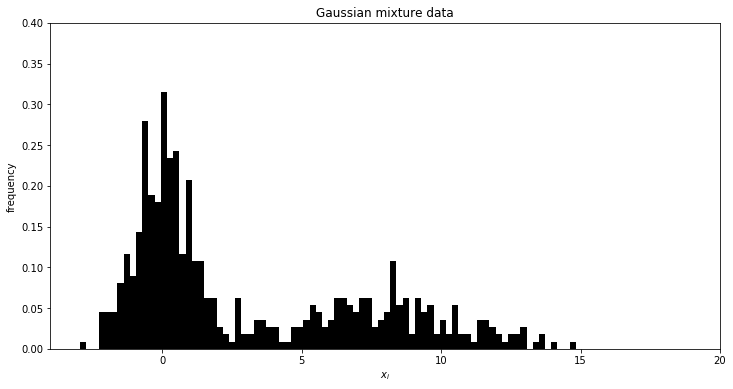

In [60]:
mu_exact = [0, 8]
sig_exact = [1, 3]
pi = 0.4 
n = 500

X = np.empty(shape=(n,2)) # x,z
for i in range(n):
    # get the component
    k = binomial(1, pi, 1)
    # sample from this component
    if k==0:
        X[i,:] = [normal(loc=mu_exact[0], scale=sig_exact[0], size=1), k]
    else:
        X[i,:] = [normal(loc=mu_exact[1], scale=sig_exact[1], size=1), k]

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(X[:,0], bins=80, color='k', density=True)
ax.set_xlim([-4,20])
ax.set_ylim([0,.4])
ax.set_title("Gaussian mixture data")
ax.set_xlabel(r"$x_i$")
ax.set_ylabel("frequency")


plt.show()


We must work out the joint distribution $$ p\left(x_{1:N}, z_{1:N}, \pi, \mu_{1:2}, \sigma_{1:2} \right)$$ and from this work out the posterior conditional distributions over the parameters and latent variables. We can try to draw a graphical model to represent the flow of dependencies here.

...



From the graphical model (which I have yet to draw), it seems like the joint probability distribution will factor as such:
$$ p\left(x_{1:N}, z_{1:N}, \pi, \mu_{1:2}, \sigma_{1:2}^2\right) = \prod_{i=1}^N p\left(x_i \, \middle| \, z_i, \sigma_{z_i}^2, \mu_{z_i} \right) p\left(\mu_{z_i} \, \middle| \, z_i \right) p\left(\sigma_{z_i}^2 \, \middle| \, z_i \right) p\left(z_i \, \middle| \, \pi \right) p\left(\pi \right)  $$ 
We can take the log of this to turn the product into a sum and simplify the math; we will do this in a moment. First, we will write out the expressions for each of the terms. These expressions come from our model: the likelihood and the priors.

The likelihood of the $i$-th observation is 
$$ p\left(x_i \, \middle| \, z_i, \mu_{z_i}, \sigma_{z_i}^2\right) = \mathcal{N}\left(x_i \, \middle| \, \mu_{z_i}, \sigma_{z_i}^2 \right) = \left(\sqrt{2\pi} \sigma_{z_i}^2 \right)^{-1} \exp\left( -\frac{1}{2}  \frac{\left(x_i - \mu_{z_i} \right)^2}{\sigma_{z_i}^2}\right) $$ 
and so the log of this is 
$$ \log p\left(x_i \, \middle| \, z_i, \mu_{z_i}, \sigma^2_{z_i}\right) = -\log \sqrt{2\pi} - \log \sigma_{z_i}^2 - \frac{1}{2} \frac{\left(x_i - \mu_{z_i} \right)^2}{\sigma_{z_i}^2} $$ 
Note that the first term is a constant.

The second term, $p\left(\mu_{z_i}\, \middle| \, z_i\right)$, describes how the distribution of $\mu_1$ and $\mu_2$ depend on the value of $z_i$. Specifically, if $z_i=0$, then $\mu_0$ and $\mu_1$ will follow some distributions. Otherwise, if $z_i=1$, they will each follow some other distributions. In our model above, we assumed that $\mu_k$ were distributed normally, independent of $z_i$. Thus, we have 
$$ p\left(\mu_{z_i}\,\middle| \, z_i\right) = p\left(\mu_0\right) = p\left(\mu_1\right)$$ where $$ \mathcal{N}\left(0,1\right) = \left(2\pi\right)^{-\frac{1}{2}} \exp \left(-\frac{1}{2} \mu^2 \right) $$ 
is the prior we chose. The log of this is  
$$ \log p\left(\mu_{z_i}\, \middle| \, z_i\right) = -\log \sqrt{2\pi} - \frac{1}{2} \mu_{z_i}^2$$

The third term is $p\left(\sigma_{z_i}^2 \, \middle| \, z_i \right)$ which describes how the variance of the likelihood of $x_i$ depends on the component assignment $z_i$. As in the previous term, it is directly independent of $z_i$ and given by an inverse Gaussian prior: $$ p\left(\sigma_{z_i}^2 \, \middle| \, z_i \right) = \text{IG}\left(1,1\right) = \frac{1}{\sqrt{2\pi \left(\sigma_{z_i}^2\right)^3}} \exp \left( -\frac{\left(\sigma_{z_i}^2-1\right)^2}{2\sigma_{z_i}^2} \right)$$ which has log $$ \log p\left(\sigma_{z_i}^2 \, \middle| \, z_i \right) = -\frac{1}{2}\log 2\pi - \frac{3}{2}\log \sigma_{z_i}^2 - \frac{\left(\sigma_{z_i}^2-1\right)^2}{2\sigma_{z_i}^2} $$

We next have the term $p\left(z_i\,\middle|\, \pi\right)$ which describes how our component assignment is distributed based on the parameter $\pi$, which is the mixture parameter. I think it looks like 
$$ p\left(z_i\,\middle|\,\pi\right) = \pi^{1-z_i}\left(1-\pi\right)^{z_i} $$
which easily has the log
$$ \log p\left(z_i\,\middle|\,\pi\right) = \left(1-z_i\right) \log \pi + z_i \log \left(1-\pi\right) $$

The last term is just the prior $p\left(\pi\right)$ over the mixture parameter, here assumed to be a beta distribution: 
$$ p\left(\pi\right) = \text{Beta}\left(1,1\right) = 1 $$
which is equivalent to a uniform distribution over $\left[0,1\right]$ but with different conjugacy properties. It has log zero and doesn't contribute to the sum.

We now take all of these terms together in the log joint distribution:
$$ \begin{align} \log p\left(x_{1:N}, z_{1:N}, \mu_{1:2}, \sigma^2_{1:2}, \pi \right) & =  \sum_{i=1}^N \left[ \log p\left(x_i \, \middle| \, z_i, \sigma_{z_i}^2, \mu_{z_i} \right)+ \log p\left(\mu_{z_i} \, \middle| \, z_i \right)+ \log p\left(\sigma_{z_i}^2 \, \middle| \, z_i \right) +\log p\left(z_i \, \middle| \, \pi \right)\right] +\log p\left(\pi \right) \\ & = \text{const.} + \sum_{i=1}^N \left[- \log \sigma_{z_i}^2 - \frac{1}{2} \frac{\left(x_i - \mu_{z_i} \right)^2}{\sigma_{z_i}^2} - \frac{1}{2} \mu_{z_i}^2 \right. \\ & \;\; \left. - \frac{3}{2}\log \sigma_{z_i}^2 - \frac{\left(\sigma_{z_i}^2-1\right)^2}{2\sigma_{z_i}^2} +\left(1-z_i\right) \log \pi + z_i \log \left(1-\pi\right) \right] \end{align} $$ 
where the constant terms were all subsumed into the constant. 

Remember that since we are summing over $i=1,\ldots,N$, we are getting a different pair of variables $\left(x_i,z_i\right)$ for each $i$. In Joe's model, it looks like this sum is broken into two parts: one where $z_i = 0$ and one where $z_i =1$. This will allow us to bring back the individual parameters $\mu_1, \mu_2, \sigma_1,$ and $\sigma_2$ instead of the general $\mu_{z_i}$, etc.

To do this splitting, we let $n$ be the number of observations which come from the first component, $z_i=0$, i.e., 
$$ n = \sum_{i=1}^N \left(1-z_i\right) $$ 
From rearranging this sum we can see that 
$$ \sum_{i=1}^N z_i = N-n $$
Even better, let 
$$\mathcal{A} = \left\{ i \, : \, z_i = 0 \right\} $$
then we can write the sum over all $i$ as
$$ \sum_{i=1}^N = \sum_{i\in\mathcal{A}} + \sum_{i\in\mathcal{A}^c} $$ 
Then $n = \left| \mathcal{A}\right|$.

### posterior conditional for $\pi$ 
Let's start with the posterior conditional for $\pi$, since that seems easiest. We just have the two terms (sums): $$ \begin{align} \log p\left(\pi \, \middle| \, x_{1:N}, z_{1:N}, \mu_{1:2}, \sigma^2_{1:2}\right) & = \sum_{i=1}^N \left[ \left(1-z_i\right)\log \pi + z_i \log \left(1-\pi\right) \right] \\  & = \log \pi \sum_{i=1}^N \left(1-z_i\right)  + \log \left(1-\pi\right) \sum_{i=1}^N z_i \\ & = n\log \pi + \left(N-n\right) \log \left(1-\pi\right) \\ & = \log \pi^n + \log \left(1-\pi\right)^{N-n}  \\ & = \log \pi^n \left(1-\pi\right)^{N-n} \end{align} $$

### posterior conditional for $\mu_1$

To get the posterior conditional for $\mu_1$ (and $\mu_2$), we can split up the sums. 

$$ \begin{align} \log p\left(\mu_{1:2} \, \middle| \, x_{1:N}, z_{1:N}, \pi, \sigma^2_{1:2} \right) & = -\frac{1}{2}\sum_{i=1}^N \left[ \frac{\left(x_i - \mu_{z_i} \right)^2}{\sigma_{z_i}^2} +\mu_{z_i}^2 \right] \\ & = -\frac{1}{2} \sum_{i\in \mathcal{A}}\left[ \frac{\left(x_i - \mu_{z_i} \right)^2}{\sigma_{z_i}^2} +\mu_{z_i}^2 \right] -\frac{1}{2} \sum_{i\in \mathcal{A^c}}\left[ \frac{\left(x_i - \mu_{z_i} \right)^2}{\sigma_{z_i}^2} +\mu_{z_i}^2 \right] \\ & = -\frac{1}{2} \sum_{i\in \mathcal{A}}\left[ \frac{\left(x_i - \mu_{1} \right)^2}{\sigma_{1}^2} +\mu_{1}^2 \right] -\frac{1}{2} \sum_{i\in \mathcal{A^c}}\left[ \frac{\left(x_i - \mu_{2} \right)^2}{\sigma_{2}^2} +\mu_{2}^2 \right] \end{align}$$ 

We see that we can decompose this into terms involving just $\mu_1$ and just $\mu_2$. Thus 

$$ \begin{align} \log p\left(\mu_{1} \, \middle| \, x_{1:N}, z_{1:N}, \pi, \mu_2, \sigma^2_{1:2} \right) & = -\frac{1}{2} \sum_{i\in \mathcal{A}}\left[ \frac{\left(x_i - \mu_{1} \right)^2}{\sigma_{1}^2} +\mu_{1}^2 \right] \\ & = -\frac{1}{2\sigma_1^2} \sum_{i \in \mathcal{A}} \left[ x_i^2 + \left(1+\sigma_1^2\right)\mu_1^2 - 2x_i\mu_1  \right] \\ & =  -\frac{1}{2\sigma_1^2} \sum_{i \in \mathcal{A}}  x_i^2 - \frac{1}{2\sigma_1^2} \sum_{i\in \mathcal{A}} \left(1+\sigma_1^2\right)\mu_1^2 + \frac{1}{\sigma_1^2} \sum_{i\in \mathcal{A}} x_i\mu_1  \\ & =  \text{const.} - \left(\frac{n\left(1+\sigma_1^2\right)}{2\sigma_1^2} \right)\mu_1^2  + \frac{1}{\sigma_1^2} \left( \sum_{i\in \mathcal{A}} x_i\right) \mu_1   \end{align}$$


There are $N$ observations $x_{1:N}$. There are $N$ latent variables $z_{1:N}$, and 5 regular variables $\pi, \mu_1, \mu_2, \sigma^2_1,$ and $\sigma^2_2$.

# Try again

$$ p\left(x_{1:N}, z_{1:N}, \mu_{1:2}, \sigma_{1:2}^2, \pi\right) = \prod_{i=1}^N p\left(x_i \, \middle| \, z_i, \mu_{z_i}, \sigma_{z_i}^2\right) p\left(\mu_{z_i} \, \middle| \, z_i \right) p\left(\sigma^2_{z_i} \, \middle| \, z_i\right) p\left(z_i\,\middle| \, \pi\right)p\left(\pi\right) $$ 
where 
$$ p\left(x_i \, \middle| \, z_i, \mu_{z_i}, \sigma_{z_i}^2\right) = \mathcal{N}\left(\mu_{z_i}, \sigma_{z_i}^2\right) $$ 
Notice that $x_i$ depends on $z_i$ through the parameters $\mu$ and $\sigma$; it will be tricky to factor everything out because we do not know ahead of time which observations came from which component. This is why the $z_i$ are latent.

$$ \begin{align} p\left(x_i \, \middle| \, z_i, \mu_{z_i}, \sigma_{z_i}^2\right)  & = \frac{1}{\sqrt{2\pi\sigma_{z_i}^2}}\exp \left( -\frac{1}{2} \frac{\left(x_i - \mu_{z_i} \right)^2}{\sigma_{z_i}^2}\right) \end{align} $$

\begin{align}\log p\left(x_i \, \middle| \, z_i, \mu_{z_i}, \sigma_{z_i}^2\right)  & = -\log \sqrt{2\pi\sigma_{z_i}^2} -\frac{1}{2} \frac{\left(x_i - \mu_{z_i} \right)^2}{\sigma_{z_i}^2} \\ & = \text{const.} - \frac{1}{2} \log \sigma_{z_i}^2 - \frac{1}{2\sigma_{z_i}^2} \left(x_i^2 + \mu_{z_i}^2 - 2\mu_{z_i}x_i\right)\end{align}

For the $\mu_{1:2}$ variables, we have  $$ p\left(\mu_{z_i}\,\middle| \, z_i \right) = \mathcal{N}\left(0,1\right) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{1}{2} \mu_{z_i}^2\right)$$ which has log $$ \log p\left(\mu_{z_i}\,\middle| \, z_i \right) = \text{const.} - \frac{1}{2} \mu_{z_i}^2 $$

For the $z_i$ variables, we have $$ p\left(z_i\, \middle| \, \pi\right) = \pi^{1-z_i}\left(1-\pi\right)^{z_i} $$ with log $$ \log p\left(z_i\,\middle|\, \pi\right) = \left(1-z_i\right) \log \pi + z_i \log \left(1-\pi\right) $$

For the $\pi$ variable, we have the prior $$ p\left(\pi\right) = \text{Beta}\left(1,1\right) \approx \text{Uniform}\left(0,1\right) = 1 $$ which is effectively the uniform distribution but with different conjugacy properties.

Lastly, $\sigma_k^2$ follows an inverse Gaussian prior, so that $$ p\left(\sigma_{z_i}^2\,\middle|\, z_i\right) = \frac{1}{\sqrt{2\pi\left(\sigma_{z_i}^2\right)^3}} \exp \left( - \frac{\left( \sigma_{z_i}^2-1\right)^2}{2\sigma_{z_i}^2}\right)$$ which has log $$ \log p\left(\sigma_{z_i}^2\,\middle|\, z_i\right) = \text{const.} + \frac{3}{2} \log \sigma_{z_i}^2 - \frac{\left( \sigma_{z_i}^2-1\right)^2}{2\sigma_{z_i}^2} $$